## 参考文献
- https://rightcode.co.jp/blog/information-technology/pytorch-mnist-learning
- https://qiita.com/TKC-tkc/items/42ff569be496621fc016

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import numpy as np

from PIL import Image
import random

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 1000) # MNISTは28*28*255 ≒ 20万のパターンがあるデータ。これを１０００次元にまで削減する
        self.fc2 = torch.nn.Linear(1000, 10) # 1000成分ベクトルを10成分ベクトルにする、これが0-9の分類に対応。各成分の値は確率。
    
    
    def forward(self,x):
        x = self.fc1(x)
        x = torch.sigmoid(x) # 活性化関数はシグモイド関数を使う
        x = self.fc2(x)

        return f.log_softmax(x, dim=1) # 出力層はsoft-max関数を使う

# ニューラルネットの定義はこれだけ！
model = Net()

参考文献
- https://qiita.com/fukuit/items/215ef75113d97560e599

In [3]:
# MNISTデータをダウンロードしてトレーニングデータとテストデータに分ける関数です
batch_size = 128
def load_MNIST(batch=batch_size, intensity=1.0):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data',
                       train=True,
                       download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x * intensity)
                       ])),
        batch_size=batch,
        shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data',
                       train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x * intensity)
                       ])),
        batch_size=batch,
        shuffle=True)

    return {'train': train_loader, 'test': test_loader}


In [4]:
# このセルで学習をします

# 学習回数
epoch = 20

# 学習結果の保存用
history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
}

# ネットワークを構築
net: torch.nn.Module = Net()

# MNISTのデータローダーを取得
loaders = load_MNIST()

# PyTorchのoptimで最適化します
# 最適化の手法はAdam（Adaptive Moment Estimation）を使います 
# https://rightcode.co.jp/blog/information-technology/torch-optim-optimizer-compare-and-verify-update-process-and-performance-of-optimization-methods
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

# エポック数の回数、iterationして学習します
for e in range(epoch):

    """ Training Part"""
    loss = None

    # 学習開始 (再開)
    net.train(True)  # 引数は省略可能
    
    # irainingデータでiterationします
    for i, (data, target) in enumerate(loaders['train']):
        data = data.view(-1, 28*28)
        
        # 勾配を0に戻しておきます
        optimizer.zero_grad()
        
        # データを定義したネットワークに入れて出力を得ます
        output = net(data)
        
        # 損失関数はNegative Log Likelihood(NLL)にします
        loss = f.nll_loss(output, target)
        
        # 損失関数の自動微分をします
        loss.backward()
        
        # 勾配を更新します
        optimizer.step()

    history['train_loss'].append(loss)

    
    # 学習のストップ
    net.train(False) # または net.eval()  でも良い
    
    # 1回のエポックの学習が終わったとき、テストデータでモデルを評価します
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.view(-1, 28 * 28)
            
            # テストデータをネットワークに入れて推論させます
            output = net(data)
            
            test_loss += f.nll_loss(output, target, reduction='sum').item()
            
            # 推論結果で確率が一番高いラベル(0-9のどの数字か)を答えます
            pred = output.argmax(dim=1, keepdim=True)
            
            # 推論結果と実際のラベルが一致していたら正解数を増やしていきます
            # 最終的に全テストデータに対して正解数をカウントします
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= 10000

    print('Test loss (avg): {}, Accuracy: {}'.format(test_loss,
                                                     correct / 10000))

    history['test_loss'].append(test_loss)
    history['test_acc'].append(correct / 10000)
    


Test loss (avg): 0.26652321329116824, Accuracy: 0.923
Test loss (avg): 0.20137797331809998, Accuracy: 0.9413
Test loss (avg): 0.1554432737827301, Accuracy: 0.9528
Test loss (avg): 0.13059054695367814, Accuracy: 0.9605
Test loss (avg): 0.1053754222869873, Accuracy: 0.9685
Test loss (avg): 0.09931395485401154, Accuracy: 0.9705
Test loss (avg): 0.08811677347421647, Accuracy: 0.9741
Test loss (avg): 0.07927880330085754, Accuracy: 0.9764
Test loss (avg): 0.07654344631433486, Accuracy: 0.9769
Test loss (avg): 0.06913545143045485, Accuracy: 0.98
Test loss (avg): 0.06770274290144443, Accuracy: 0.98
Test loss (avg): 0.06600883802175522, Accuracy: 0.9797
Test loss (avg): 0.0643732629980892, Accuracy: 0.9809
Test loss (avg): 0.06710352778687374, Accuracy: 0.98
Test loss (avg): 0.06810319705232978, Accuracy: 0.9801
Test loss (avg): 0.06275825496017932, Accuracy: 0.9815
Test loss (avg): 0.0644100649356842, Accuracy: 0.981
Test loss (avg): 0.06685554550886154, Accuracy: 0.9812
Test loss (avg): 0.067

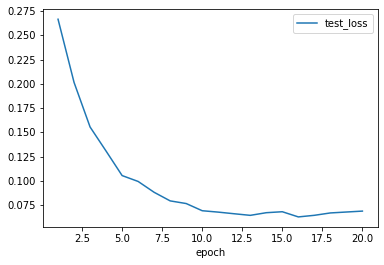

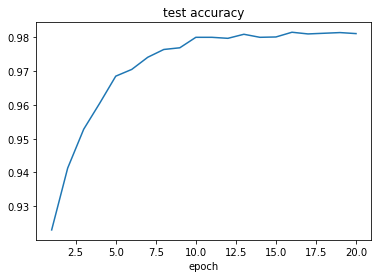

In [5]:
# 結果の出力と描画
plt.figure()
#plt.plot(range(1, epoch+1), history['train_loss'], label='train_loss')
plt.plot(range(1, epoch+1), history['test_loss'], label='test_loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('loss.png')

plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc.png')

In [75]:
def compare_test_data_image_with_label(loaders):
    # テストデータをランダムに抽出
    test_data_length = len(loaders["test"])
    test_data_list = list(loaders['test'])[random.randint(0, test_data_length - 1)]

    # こいつがバッチサイズの長さを持っているのでさらにバッチサイズの範囲の乱数で抽選してnumpy arrayにする
    random_index = random.randint(0, batch_size - 1)
    sample_test_data_image = test_data_list[0][random_index].detach().numpy().copy()

    # MNISTの大きさの28*28にreshapeして0-255の整数にする
    sample_test_data_image = (sample_test_data_image.reshape(28,28)*255).astype(int)

    # ラベルを表示
    sample_test_data_label = test_data_list[1][random_index].item()
    print("Correct number is {}".format(sample_test_data_label))
    
    # 画像を表示
    plt.imshow(sample_test_data_image, cmap='gray')
    plt.show()
    

Correct number is 2


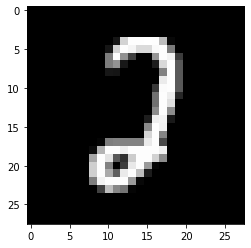

Correct number is 5


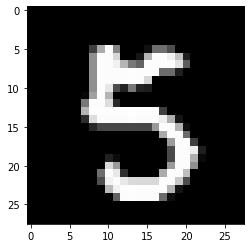

Correct number is 5


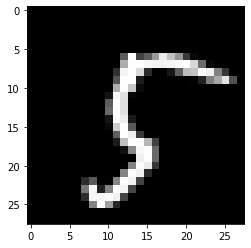

Correct number is 6


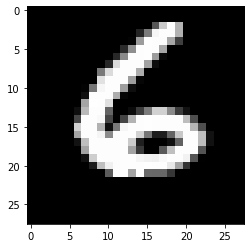

Correct number is 9


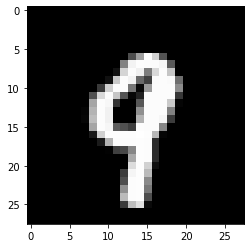

Correct number is 7


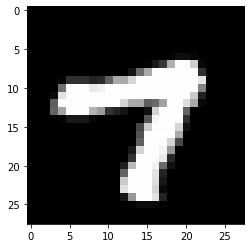

Correct number is 8


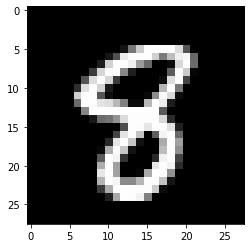

Correct number is 3


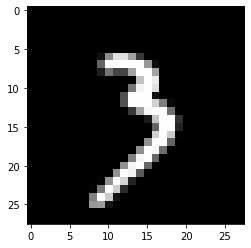

Correct number is 1


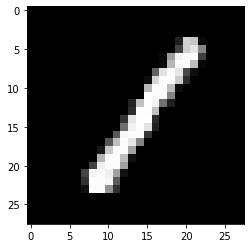

Correct number is 5


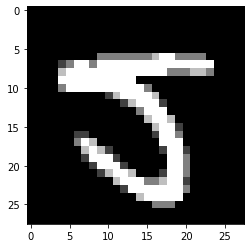

In [76]:
for i in range(10):
    compare_test_data_image_with_label(loaders)
